In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

# Load the dataset
df = pd.read_csv("../datasets/bioresponse.csv")

# Separate features and target
X = df.drop(columns=["Activity"])
y = df["Activity"]

# Split the dataset into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Shallow decision tree
shallow_tree = DecisionTreeClassifier(max_depth=3)
shallow_tree.fit(X_train, y_train)

# 2. Deep decision tree
deep_tree = DecisionTreeClassifier(max_depth=None)
deep_tree.fit(X_train, y_train)

# 3. Spanning tree on shallow trees (I'm assuming you mean Bagging with shallow trees)
bagging_on_shallow_trees = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=50, random_state=42)
bagging_on_shallow_trees.fit(X_train, y_train)

# 4. Random forest on deep trees
random_forest_on_deep_trees = RandomForestClassifier(max_depth=None, n_estimators=50, random_state=42)
random_forest_on_deep_trees.fit(X_train, y_train)

print("All models trained!")


/Users/nazarii_mozol/projects/studing/Machine-Learning/osx-venv-3_12/lib/python3.12/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


All models trained!


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss

# Dictionary to store results
metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Log Loss': []
}

# List of models
models = [
    ("Shallow Decision Tree", shallow_tree),
    ("Deep Decision Tree", deep_tree),
    ("Bagging on Shallow Trees", bagging_on_shallow_trees),
    ("Random Forest on Deep Trees", random_forest_on_deep_trees)
]

# Calculate and store metrics for each model
for model_name, model in models:
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    loss = log_loss(y_test, y_pred_proba)

    metrics['Model'].append(model_name)
    metrics['Accuracy'].append(accuracy)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1 Score'].append(f1)
    metrics['Log Loss'].append(loss)

# Convert dictionary to DataFrame for better visualization
results_df = pd.DataFrame(metrics)

print(results_df)


                         Model  Accuracy  Precision    Recall  F1 Score  \
0        Shallow Decision Tree  0.760320   0.786848  0.801386  0.794050   
1           Deep Decision Tree  0.704394   0.739229  0.752887  0.745995   
2     Bagging on Shallow Trees  0.769640   0.785088  0.826790  0.805399   
3  Random Forest on Deep Trees  0.794940   0.825175  0.817552  0.821346   

    Log Loss  
0   0.537061  
1  10.654715  
2   0.512719  
3   0.452628  


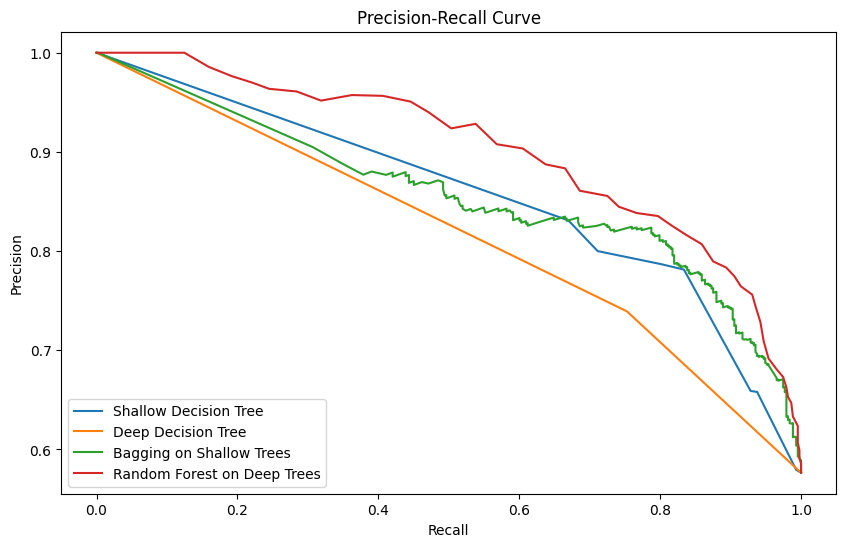

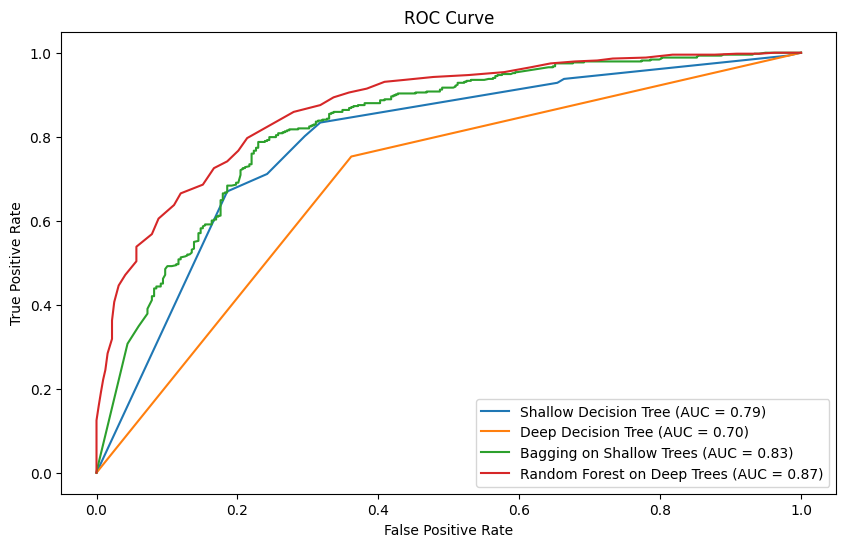

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc

# Function to plot precision-recall curve
def plot_precision_recall_curve(y_true, y_pred_proba, label=None):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba[:, 1])
    plt.plot(recall, precision, label=label)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_proba, label=None):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

# Plot Precision-Recall curves for all models
plt.figure(figsize=(10, 6))
for model_name, model in models:
    y_pred_proba = model.predict_proba(X_test)
    plot_precision_recall_curve(y_test, y_pred_proba, label=model_name)
plt.show()

# Plot ROC curves for all models
plt.figure(figsize=(10, 6))
for model_name, model in models:
    y_pred_proba = model.predict_proba(X_test)
    plot_roc_curve(y_test, y_pred_proba, label=model_name)
plt.show()


In [32]:
from sklearn.metrics import confusion_matrix

def adjusted_predictions(model, X, threshold=0.5):
    """Return predictions based on the adjusted threshold."""
    return (model.predict_proba(X)[:, 1] >= threshold).astype(int)

# Find threshold that maximizes recall for each model
thresholds = {}
for model_name, model in models:
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds_values = precision_recall_curve(y_test, y_pred_proba)
    # Get the threshold for the maximum recall
    thresholds[model_name] = thresholds_values[recall[:-1].argmax()]

# Calculate metrics using adjusted threshold
metrics_adjusted = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Log Loss': []
}

for model_name, model in models:
    y_pred_adjusted = adjusted_predictions(model, X_test, thresholds[model_name])
    y_pred_proba = model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    loss = log_loss(y_test, y_pred_proba)

    metrics_adjusted['Model'].append(model_name)
    metrics_adjusted['Accuracy'].append(accuracy)
    metrics_adjusted['Precision'].append(precision)
    metrics_adjusted['Recall'].append(recall)
    metrics_adjusted['F1 Score'].append(f1)
    metrics_adjusted['Log Loss'].append(loss)

# Display results
results_adjusted_df = pd.DataFrame(metrics_adjusted)
print(results_adjusted_df)


                         Model  Accuracy  Precision  Recall  F1 Score  \
0        Shallow Decision Tree  0.576565   0.576565     1.0  0.731419   
1           Deep Decision Tree  0.576565   0.576565     1.0  0.731419   
2     Bagging on Shallow Trees  0.576565   0.576565     1.0  0.731419   
3  Random Forest on Deep Trees  0.576565   0.576565     1.0  0.731419   

    Log Loss  
0   0.537061  
1  10.654715  
2   0.512719  
3   0.452628  


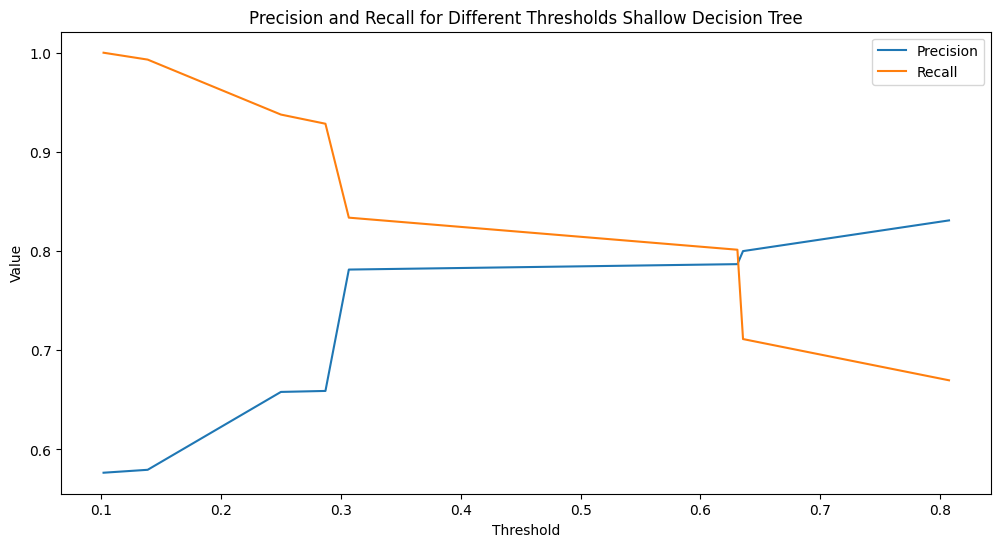

Accuracy: 0.7603
Precision: 0.7868
Recall: 0.8014
F1 Score: 0.7941
Log Loss: 0.5371


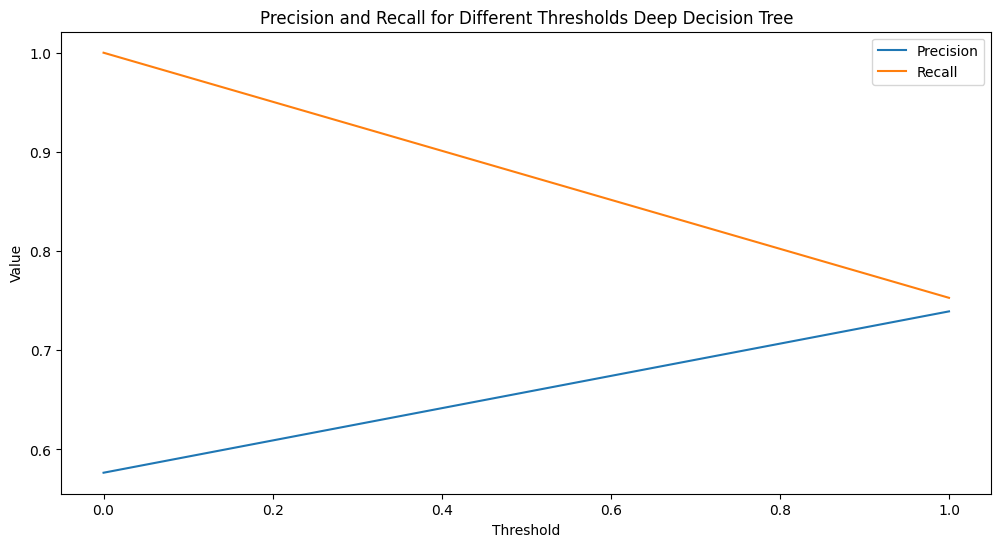

Accuracy: 0.7044
Precision: 0.7392
Recall: 0.7529
F1 Score: 0.7460
Log Loss: 10.6547


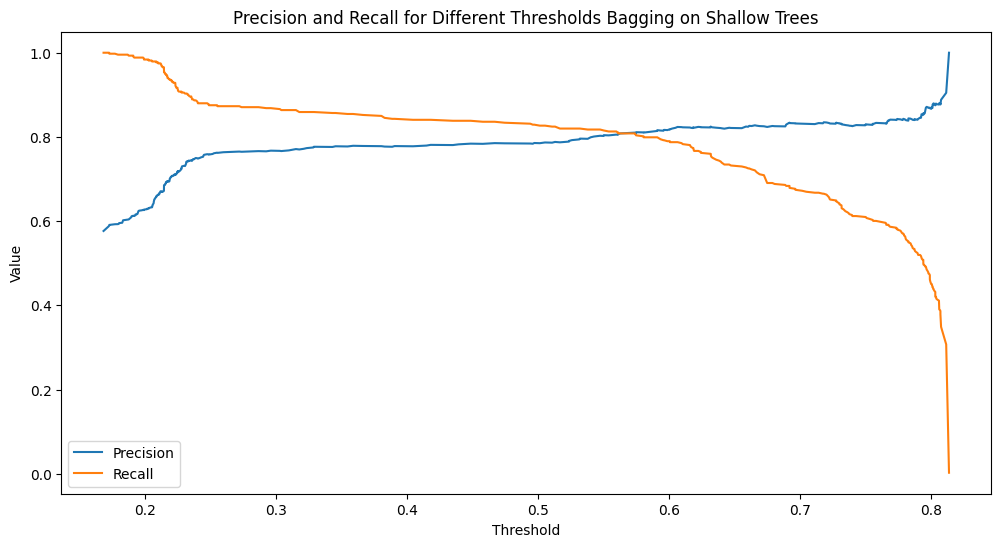

Accuracy: 0.7696
Precision: 0.7778
Recall: 0.8406
F1 Score: 0.8080
Log Loss: 0.5127


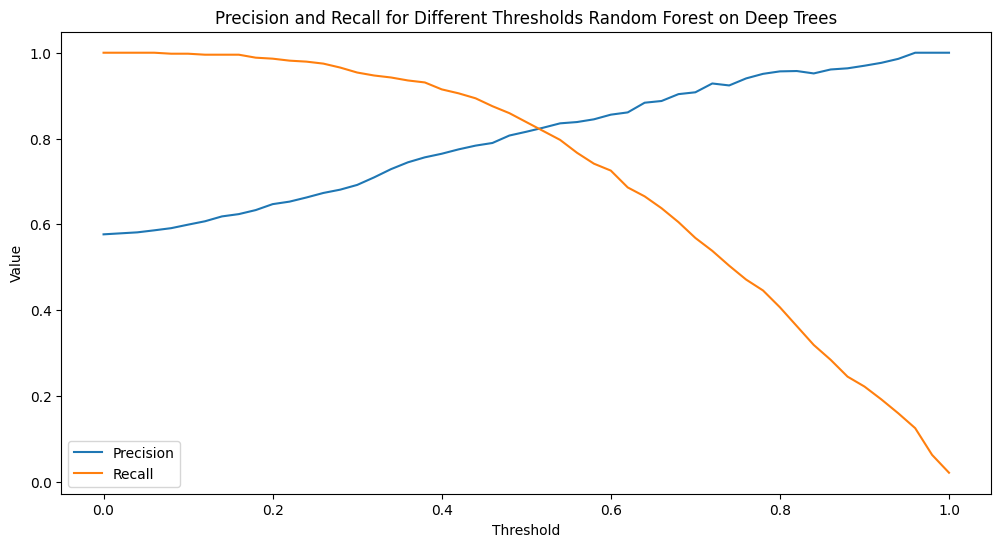

Accuracy: 0.7883
Precision: 0.7645
Recall: 0.9145
F1 Score: 0.8328
Log Loss: 0.4526


In [33]:
from sklearn.metrics import precision_recall_curve

# Let's take one of your trained models as an example:
#model_example = models[3][1]  # Taking Shallow Decision Tree as an example

for name,  model_example in models:
    # Get predicted probabilities
    y_pred_proba_example = model_example.predict_proba(X_test)[:, 1]

    # Get precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_example)

    # Plot precision and recall for different thresholds
    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, precision[:-1], label='Precision')
    plt.plot(thresholds, recall[:-1], label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Value')
    plt.title('Precision and Recall for Different Thresholds ' + str(name))
    plt.legend()
    plt.show()

    def adjusted_predictions_with_threshold(model, X, threshold=0.5):
        """Return predictions based on the specified threshold."""
        return (model.predict_proba(X)[:, 1] >= threshold).astype(int)

    # For demonstration, let's say we selected a threshold of 0.4 based on the plot
    new_threshold = 0.4
    y_pred_adjusted_example = adjusted_predictions_with_threshold(model_example, X_test, new_threshold)

    # Calculate the quality metrics for adjusted predictions
    accuracy = accuracy_score(y_test, y_pred_adjusted_example)
    precision = precision_score(y_test, y_pred_adjusted_example)
    recall = recall_score(y_test, y_pred_adjusted_example)
    f1 = f1_score(y_test, y_pred_adjusted_example)
    # For log loss, you need the predicted probabilities, not the binary predictions
    loss = log_loss(y_test, model_example.predict_proba(X_test))

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Log Loss: {loss:.4f}")
